In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
import importlib
from plot_mi_metric import plot_mi_wrt_clusters

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# choose GPU
torch.cuda.set_device(3)
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
4
3
cuda


In [3]:
num_clusters = 6

In [4]:
data_dir = './data/eeg'

In [5]:
print('reading data ...')
# 25 is subject id, see more details in the respective directory.
data = pd.read_csv(data_dir+'/raw_data/25.csv', header=None).values.T
print(f'data.shape={data.shape}')
# last 10000 observations for modeling since some of the baselines such as Spectral clustering can't deal with high dimensionality in terms of compute cost (besides quality of clusters) making it difficult to evaluate the baselines.
# the proposed method as well as some of the deep learning based baselines are robust to high dimensionality in terms of compute cost as well as quality of clusters
# a separate notebook is released, evaluating our method when using all the observations
data = data[:, -10000:]
print('done.')

print(f'data.shape={data.shape}')

reading data ...
data.shape=(74, 909312)
done.
data.shape=(74, 10000)


In [6]:
# number of sensors (to be clustered)
n = data.shape[0]

In [7]:
%%time

import timeseries_dependency_scores as tds
importlib.reload(tds)

# it can be expensive to compute mutual information between every pair of timeseries (74 in this case), which is required for evaluating the clusters, so it's easier to just load it from the data directory
# note that this metric is completely independent in its formulation from the information objective of mutual information for clustering
# this is used only for the purpose for evaluation of clusters from different methods, not for optimizing clusters 
fresh_compute = False

if fresh_compute:
    mi_scores = tds.TimeseriesDependencyScores(metric='mi', num_cores=74).compute_dependency_scores(time_series_data=data)
    np.save(data_dir+'/mi_scores', mi_scores)
else:
    mi_scores = np.load(data_dir+'/mi_scores.npy')

CPU times: user 24.7 ms, sys: 38.2 ms, total: 63 ms
Wall time: 728 ms


In [8]:
plt.rcParams['figure.dpi'] = 80

# kNN clustering

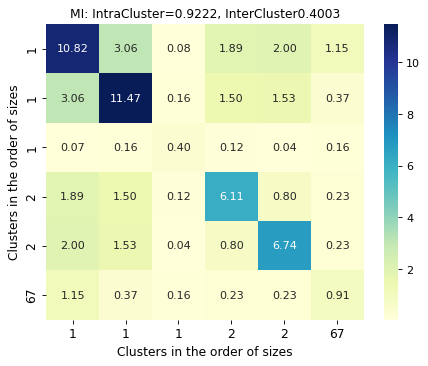

CPU times: user 8min 17s, sys: 1min 16s, total: 9min 34s
Wall time: 4.78 s


In [9]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
kmeans_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='kmeans')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, kmeans_cluster_labels)

# Spectral clustering

/a/stor125ncs2.virginia.ms.com/sc34972/s182224/venvs/tenv/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


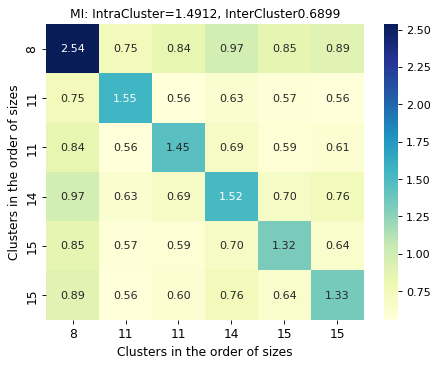

CPU times: user 385 ms, sys: 129 ms, total: 513 ms
Wall time: 372 ms


In [10]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
spectral_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='spectral',
    data=data,
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, spectral_cluster_labels)

# ITC clustering via kNN (using the mutual information objective)

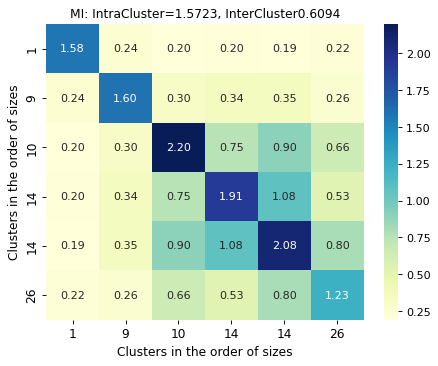

In [11]:
import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_knn_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_knn',
    data=data+1e-100*sampler.rand(data.shape[0], data.shape[1])
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_knn_cluster_labels)

# ITC clustering via minimum spanning tree (using the mutual information objective)

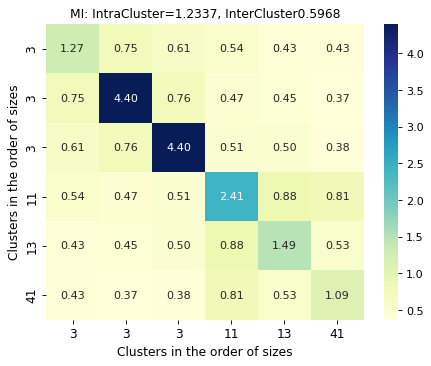

CPU times: user 546 ms, sys: 192 ms, total: 738 ms
Wall time: 546 ms


In [12]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_mst_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_mst',
    data=data+1e-10*sampler.rand(data.shape[0], data.shape[1]),
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_mst_cluster_labels)

# Our ITC-DM approach with LSTMs

....................................................................................................Cluster Sizes [60 14]
....................................................................................................Cluster Sizes [ 7 14 53]
....................................................................................................Cluster Sizes [ 7 14 14 39]
....................................................................................................Cluster Sizes [ 7 14 14  3 36]
....................................................................................................Cluster Sizes [ 7 14 14  3 18 18]
..............................

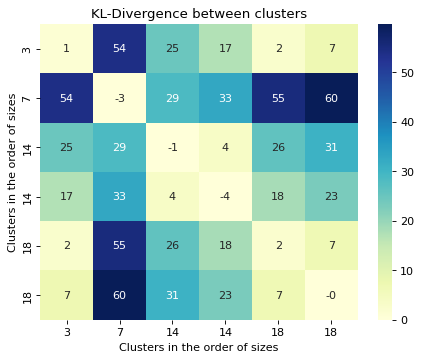

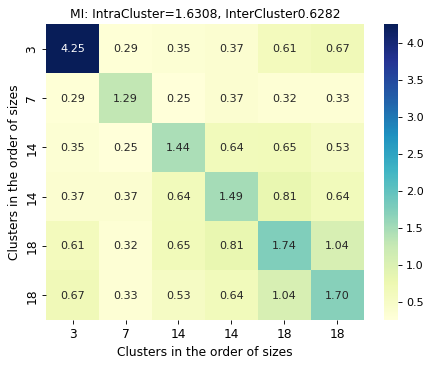

CPU times: user 45.6 s, sys: 3.02 s, total: 48.6 s
Wall time: 56.8 s


In [13]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering()

cluster_labels_itc_dv_lstm = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    # LSTMs, in some cases, can process only a small number of steps (10).     
    X_org=data.reshape(data.shape[0], 10, -1),
    # lower learning rate than the default of 1e-1 is preferred here.     
    lr=1e-2,
    num_layers=3,
    hidden_size=128,
    num_clusters=6,
    nn='lstm',
    device=device,
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
# for transformers, it is fine to process a timeseries as many steps (100 here)
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 100, -1),
     c=cluster_labels_itc_dv_lstm,
     num_iter=3000,
     num_layers=1,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_lstm)

# Our ITC-DM approach with Transformers

....................................................................................................Cluster Sizes [35 39]
....................................................................................................Cluster Sizes [35 19 20]
....................................................................................................Cluster Sizes [18 19 20 17]
....................................................................................................Cluster Sizes [18 19 10 17 10]
....................................................................................................Cluster Sizes [18 10 10 17 10  9]
..............................................................................................................

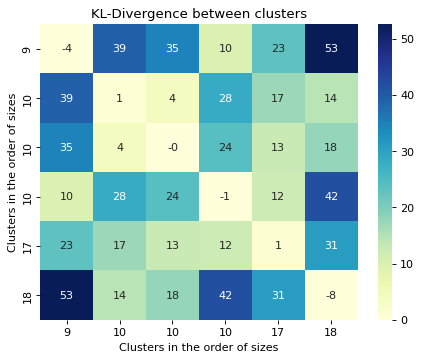

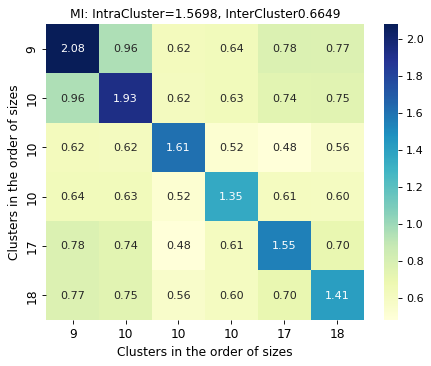

CPU times: user 3min 34s, sys: 5.66 s, total: 3min 39s
Wall time: 3min 38s


In [14]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_transformer = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
     # for transformers, it is fine to process a timeseries as many steps (100 here)
    X_org=data.reshape(data.shape[0], 100, -1),
    num_layers=6,
    hidden_size=64,
    num_clusters=6,
    device=device,
    nn='transformer',
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
# for transformers, it is fine to process a timeseries as many steps (100 here)
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 100, -1),
     c=cluster_labels_itc_dv_transformer,
     num_iter=3000,
     num_layers=1,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_transformer)